In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt
from PIL import Image

import os
import zipfile
import requests
import shutil
import random
import pathlib
from pathlib import Path
from typing import Tuple, Dict, List

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_test_timer(start, end, device):
  total_time = end - start
  print(f"Waktu training menggunakan {device}: {total_time} second")
  return total_time


In [ ]:
drive_path = Path("gdrive/MyDrive/datasets")

data_path = Path("data/")
image_path = data_path / "rockpaperscissors"

if image_path.is_dir():
    print(f"{image_path} sudah ada.")
else:
    print(f"Tidak menemukan {image_path} directory, sedang membuat...")
    image_path.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(drive_path / "rockpaperscissors.zip", "r") as zip_ref:
        print("Unzipping rock paper scissors data...")
        zip_ref.extractall(image_path)

data/rockpaperscissors sudah ada.


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(100, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(size=(100, 150)),
    transforms.ToTensor()
])

In [ ]:
data_dir = "data/rockpaperscissors/rockpaperscissors/rps-cv-images"
class_dir = os.listdir(data_dir)
class_dir = [img for img in class_dir if os.path.isdir(os.path.join(data_dir, img))]

In [ ]:
dataset = list(pathlib.Path(data_dir).glob("*/*.png"))

In [ ]:
train_set, valid_set = train_test_split(dataset, test_size=0.4, random_state=42)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, classes, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.class_names = classes
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}

    def load_image(self, index: int) -> Image.Image:
        image_path = self.dataset[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.dataset[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [ ]:
train_dataset = CustomDataset(dataset=train_set, classes=class_dir, transform=train_transform)
valid_dataset = CustomDataset(dataset=valid_set, classes=class_dir, transform=val_transform)

In [ ]:
def display_random_image(dataset: torch.utils.data.dataset.Dataset,
                         classes,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int=None):
  if n > 10:
    n = 10
    display_shape = False
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 16))

  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

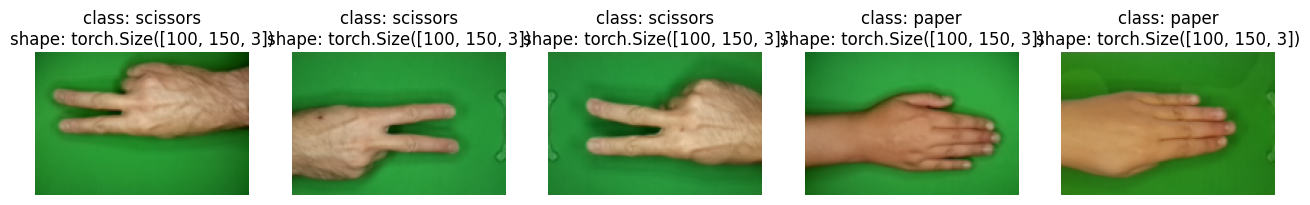

In [ ]:
display_random_image(train_dataset,
                     n = 5,
                     classes = class_dir)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

valid_dataloader = DataLoader(valid_dataset,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def valid_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  valid_loss, valid_acc = 0,  0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      valid_pred_logits = model(X)

      loss = loss_fn(valid_pred_logits, y)
      valid_loss += loss.item()

      valid_pred_labels = valid_pred_logits.argmax(dim=1)
      valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))

  valid_loss = valid_loss / len(dataloader)
  valid_acc = valid_acc / len(dataloader)
  return valid_loss, valid_acc

In [ ]:
def latihan(model: torch.nn.Module,
            train_dataloader,
            valid_dataloader,
            optimizer,
            loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 5,
            device = device):

  results = {"train_loss": [],
             "train_acc": [],
             "valid_loss": [],
             "valid_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    valid_loss, valid_acc = valid_step(model = model,
                                       dataloader = valid_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)


    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Valid loss: {valid_loss:.4f} | Valid acc: {valid_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["valid_loss"].append(valid_loss)
    results["valid_acc"].append(valid_acc)

  return results

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
            )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [ ]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=7168, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001)

In [ ]:
epochs = 10
train_time_start_model_0 = timer()

latihan_model_0 = latihan(model=model,
                       train_dataloader=train_dataloader,
                       valid_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

train_time_end_model_0 = timer()

train_test_timer(start = train_time_start_model_0,
                 end = train_time_end_model_0,
                 device = str(next(model.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1077 | Train acc: 0.3979 | Valid loss: 0.9769 | Valid acc: 0.5115
Epoch: 1 | Train loss: 0.6374 | Train acc: 0.7500 | Valid loss: 0.2948 | Valid acc: 0.9085
Epoch: 2 | Train loss: 0.2119 | Train acc: 0.9306 | Valid loss: 0.1831 | Valid acc: 0.9464
Epoch: 3 | Train loss: 0.1515 | Train acc: 0.9527 | Valid loss: 0.2478 | Valid acc: 0.9230
Epoch: 4 | Train loss: 0.1344 | Train acc: 0.9619 | Valid loss: 0.1594 | Valid acc: 0.9453
Epoch: 5 | Train loss: 0.0909 | Train acc: 0.9733 | Valid loss: 0.1622 | Valid acc: 0.9442
Epoch: 6 | Train loss: 0.0819 | Train acc: 0.9726 | Valid loss: 0.2544 | Valid acc: 0.9420
Epoch: 7 | Train loss: 0.1165 | Train acc: 0.9642 | Valid loss: 0.1707 | Valid acc: 0.9498
Epoch: 8 | Train loss: 0.0626 | Train acc: 0.9809 | Valid loss: 0.2056 | Valid acc: 0.9498
Epoch: 9 | Train loss: 0.0789 | Train acc: 0.9710 | Valid loss: 0.1488 | Valid acc: 0.9531
Waktu training menggunakan cpu: 611.9622860640011 second


611.9622860640011

In [ ]:
def plot_loss_kurva(hasil_latihan: Dict[str, list[float]]):
  loss = hasil_latihan["train_loss"]
  valid_loss = hasil_latihan["valid_loss"]

  accuracy = hasil_latihan["train_acc"]
  valid_acc = hasil_latihan["valid_acc"]

  epochs = range(len(hasil_latihan["train_loss"]))

  plt.figure(figsize = (15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, valid_loss, label = "valid_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, valid_acc, label = "valid_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

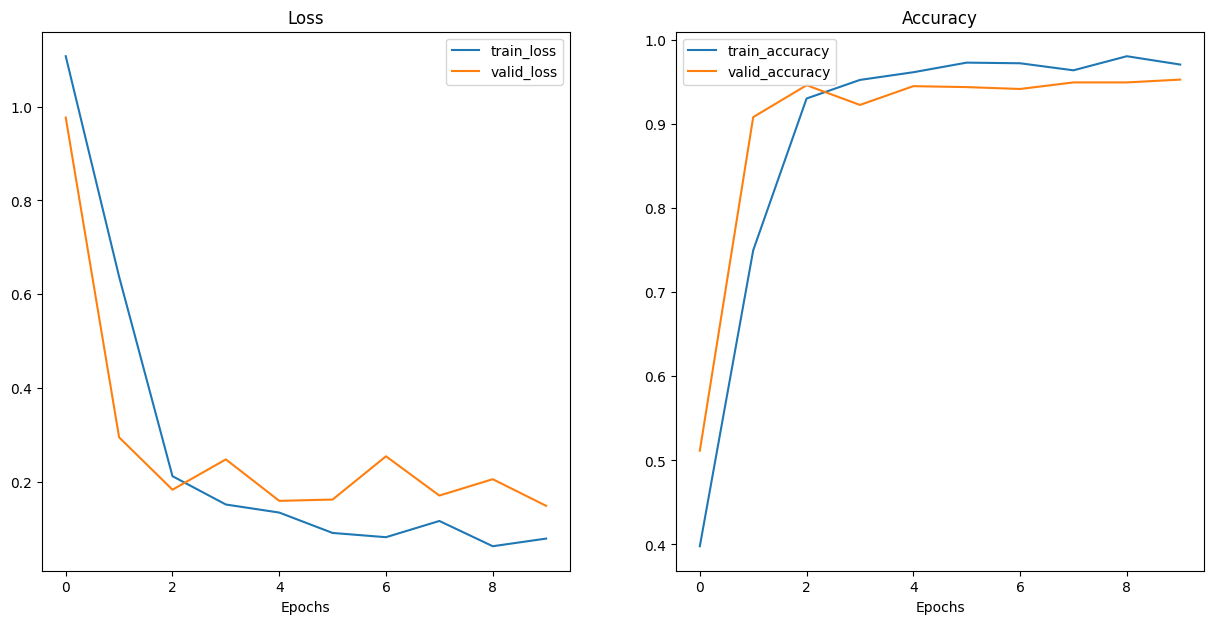

In [ ]:
plot_loss_kurva(latihan_model_0)

In [ ]:
gambar_path = "gambar_internet"

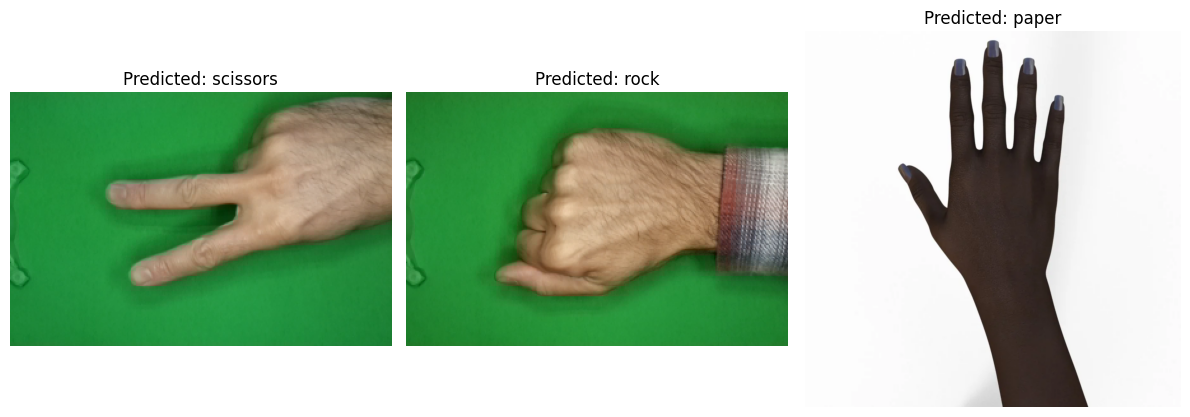

In [ ]:
nrows = 4
ncols = 4
max_images = nrows * ncols

plt.figure(figsize=(16, 16))

i = 0

for filename in os.listdir(gambar_path):
    image_path = os.path.join(gambar_path, filename)
    if os.path.isfile(image_path):
      img = Image.open(image_path)

      img_transformed = val_transform(img).unsqueeze(0)

      img_transformed = img_transformed.to(device)

      with torch.no_grad():
          output = model(img_transformed)
          probabilities = torch.softmax(output, dim=1)
          predicted_class = torch.argmax(probabilities, dim=1).item()
          predicted_class_label = class_dir[predicted_class]

      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(img)
      plt.title(f'Predicted: {predicted_class_label}')
      plt.axis('off')

      i += 1

      if i >= max_images:
          break

plt.tight_layout()
plt.show()